## Change in PSD during Deep Breathing

In [1]:
import numpy as np
import math
import random
import statistics
import matplotlib.pyplot as plt
from scipy import signal
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from statistics import mean
import time
from progressbar import progressbar

In [2]:
f_sampling = 500
source_file_RS = '../dataset/Merged_RS_Rejected.txt'
source_file_DB = '../dataset/Merged_DB_Rejected.txt'

In [3]:
def plot_PSD(f, psd, title):
    plt.semilogy(f, psd)
    plt.ylim([1e-3, 100])
    plt.xlim([6, 15])
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD')
    plt.title(title)
    plt.show()

In [4]:
def get_theta(psd, f):
    theta_psd = []
    theta_f = []

    for i in range (len(psd)):
        if (f[i] >= 4 and f[i] <= 8):
            theta_psd.append(psd[i])
            theta_f.append(f[i])
    return theta_psd, theta_f

In [5]:
def get_alpha(psd, f):
    alpha_psd = []
    alpha_f = []

    for i in range (len(psd)):
        if (f[i] >= 8 and f[i] <= 12):
            alpha_psd.append(psd[i])
            alpha_f.append(f[i])
    return alpha_psd, alpha_f

In [6]:
def get_beta(psd, f):
    beta_psd = []
    beta_f = []

    for i in range (len(psd)):
        if (f[i] >= 13 and f[i] <= 30):
            beta_psd.append(psd[i])
            beta_f.append(f[i])
    return beta_psd, beta_f

In [7]:
def freq_scaling(f, old_sig, factor):
    len_new = 0
    for i in range (0, len(f),factor):
        len_new = len_new + 1

    f_new = np.zeros(shape=len_new)
    psd_new = np.zeros(shape=len_new)

    index = 0
    for i in range (0,len(f),factor):
        f_new[index] = f[i]
        psd_new[index] = psd[i]
        index = index + 1
    return f_new, psd_new

In [8]:
Time_a, Fp1_a, Fz_a, F3_a, F7_a, FT9_a, FC5_a, FC1_a, C3_a, T7_a, TP9_a, CP5_a, CP1_a, Pz_a, P3_a, P7_a, O1_a, Oz_a, O2_a, P4_a, P8_a, TP10_a, CP6_a, CP2_a, C4_a, T8_a, FT10_a, FC6_a, FC2_a, F4_a, F8_a, Fp2_a = np.loadtxt( 
    source_file_RS, 
    skiprows = 1, #If top title row present
    unpack = True)
Time_b, Fp1_b, Fz_b, F3_b, F7_b, FT9_b, FC5_b, FC1_b, C3_b, T7_b, TP9_b, CP5_b, CP1_b, Pz_b, P3_b, P7_b, O1_b, Oz_b, O2_b, P4_b, P8_b, TP10_b, CP6_b, CP2_b, C4_b, T8_b, FT10_b, FC6_b, FC2_b, F4_b, F8_b, Fp2_b = np.loadtxt( 
    source_file_DB,
    skiprows = 1, #If top title row present
    unpack = True)

In [9]:
motor_elec_name = ["F3","Fz","F4","FC1","FC2","C3","C4","CP1","CP2","P3","Pz","P4"]
motor_elec_RS_mat = np.stack((F3_a, Fz_a, F4_a, FC1_a, FC2_a, C3_a, C4_a, CP1_a, CP2_a, P3_a, Pz_a, P4_a))
motor_elec_DB_mat = np.stack((F3_b, Fz_b, F4_b, FC1_b, FC2_b, C3_b, C4_b, CP1_b, CP2_b, P3_b, Pz_b, P4_b))

DB_induced_PSD_change_theta = np.zeros(shape=len(motor_elec_name))
DB_induced_PSD_change_alpha = np.zeros(shape=len(motor_elec_name))
DB_induced_PSD_change_beta = np.zeros(shape=len(motor_elec_name))

RS_variance_alpha = np.zeros(shape=len(motor_elec_name))
DB_variance_alpha = np.zeros(shape=len(motor_elec_name))

RS_variance_beta = np.zeros(shape=len(motor_elec_name))
DB_variance_beta = np.zeros(shape=len(motor_elec_name))

RS_variance_theta = np.zeros(shape=len(motor_elec_name))
DB_variance_theta = np.zeros(shape=len(motor_elec_name))

### a - Resting State ; b - Deep Breathing

In [10]:
for electrode in progressbar(range (len(motor_elec_name))):
    f, psd = signal.periodogram(motor_elec_RS_mat[electrode], f_sampling)
    #f, psd = freq_scaling(f, psd,100)
    
    a_theta_psd, a_theta_f = get_theta(psd, f)
    a_alpha_psd, a_alpha_f = get_alpha(psd, f)
    a_beta_psd, a_beta_f = get_beta(psd, f)

    f, psd = signal.periodogram(motor_elec_DB_mat[electrode], f_sampling)
    #f, psd = freq_scaling(f, psd, 100)
    
    b_theta_psd, b_theta_f = get_theta(psd, f)
    b_alpha_psd, b_alpha_f = get_alpha(psd, f)
    b_beta_psd, b_beta_f = get_beta(psd, f)
    
    RS_mean = mean(a_theta_psd)
    DB_mean = mean(b_theta_psd)
    DB_induced_PSD_change_theta[electrode] = ((DB_mean - RS_mean)/RS_mean)*100
    
    RS_mean = mean(a_alpha_psd)
    DB_mean = mean(b_alpha_psd)
    DB_induced_PSD_change_alpha[electrode] = ((DB_mean - RS_mean)/RS_mean)*100
    
    RS_mean = mean(a_beta_psd)
    DB_mean = mean(b_beta_psd)
    DB_induced_PSD_change_beta[electrode] = ((DB_mean - RS_mean)/RS_mean)*100
    
    RS_variance_theta[electrode] = statistics.variance(a_theta_psd)
    DB_variance_theta[electrode] = statistics.variance(b_theta_psd)  
    
    RS_variance_alpha[electrode] = statistics.variance(a_alpha_psd)
    DB_variance_alpha[electrode] = statistics.variance(b_alpha_psd)
    
    RS_variance_beta[electrode] = statistics.variance(a_beta_psd)
    DB_variance_beta[electrode] = statistics.variance(b_beta_psd)  

100% (12 of 12) |########################| Elapsed Time: 0:00:08 Time:  0:00:08


In [19]:
print ("For Theta Waves")
for i in range (len(motor_elec_name)):
    print (motor_elec_name[i],"Power decrease during DB in 04-08Hz range (%) \t =",DB_induced_PSD_change_theta[i],"%")
print ("\n")

print ("For Alpha Waves")
for i in range (len(motor_elec_name)):
    print (motor_elec_name[i],"Power decrease during DB in 08-12Hz range (%) \t =",DB_induced_PSD_change_alpha[i],"%")
print ("\n")

print ("For Beta Waves")
for i in range (len(motor_elec_name)):
    print (motor_elec_name[i],"Power decrease during DB in 13-30Hz range (%) \t =",DB_induced_PSD_change_beta[i],"%")

For Theta Waves
F3 Power decrease during DB in 04-08Hz range (%) 	 = -14.695356329975517 %
Fz Power decrease during DB in 04-08Hz range (%) 	 = -32.61209176649497 %
F4 Power decrease during DB in 04-08Hz range (%) 	 = -46.38049108560573 %
FC1 Power decrease during DB in 04-08Hz range (%) 	 = -20.85173794894736 %
FC2 Power decrease during DB in 04-08Hz range (%) 	 = -45.715736701411 %
C3 Power decrease during DB in 04-08Hz range (%) 	 = -25.15714883673198 %
C4 Power decrease during DB in 04-08Hz range (%) 	 = -45.2253224449229 %
CP1 Power decrease during DB in 04-08Hz range (%) 	 = -20.44911815476308 %
CP2 Power decrease during DB in 04-08Hz range (%) 	 = -22.79685289668755 %
P3 Power decrease during DB in 04-08Hz range (%) 	 = -12.118977696600508 %
Pz Power decrease during DB in 04-08Hz range (%) 	 = -11.266163985878759 %
P4 Power decrease during DB in 04-08Hz range (%) 	 = -3.413777217016143 %


For Alpha Waves
F3 Power decrease during DB in 08-12Hz range (%) 	 = -27.172349177440612 %

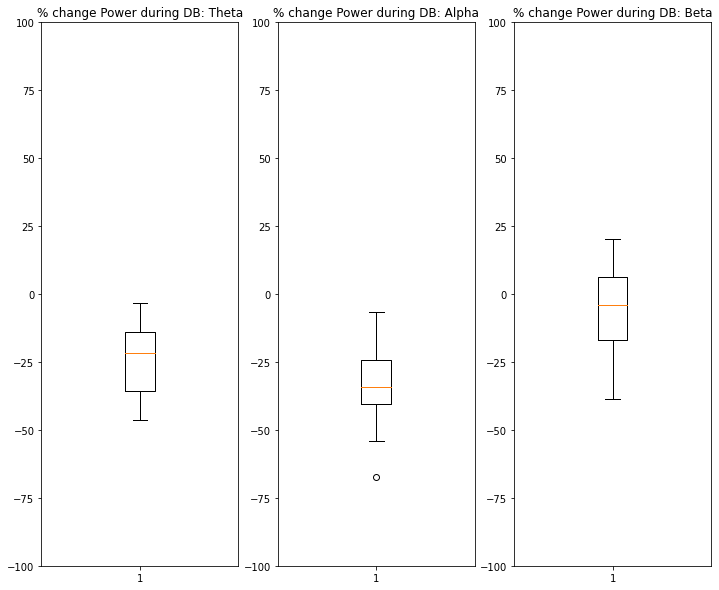

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 10))

axes[0].boxplot(DB_induced_PSD_change_theta)
axes[0].set_ylim([-100, 100])

axes[1].boxplot(DB_induced_PSD_change_alpha)
axes[1].set_ylim([-100, 100])

axes[2].boxplot(DB_induced_PSD_change_beta) 
axes[2].set_ylim([-100, 100])

axes[0].title.set_text('% change Power during DB: Theta')
axes[1].title.set_text('% change Power during DB: Alpha')
axes[2].title.set_text('% change Power during DB: Beta')
plt.show()

## Variance during Resting State and Deep Breathing - Alpha range

Electrode wise variance in resting state data - alpha waves
F3 variance =	 2.018210601033156
Fz variance =	 3.0844922108108794
F4 variance =	 2.1082799417473876
FC1 variance =	 1.6630073451668845
FC2 variance =	 1.5966255855556812
C3 variance =	 2.4762758113495673
C4 variance =	 3.418957530468148
CP1 variance =	 2.17029451777186
CP2 variance =	 2.1680574503661796
P3 variance =	 5.331956611079622
Pz variance =	 4.5753825621732895
P4 variance =	 12.960084029536546


Electrode wise variance in deep breathing data - alpha waves
F3 variance =	 1.1365434771529894
Fz variance =	 1.3374758075126152
F4 variance =	 0.9925747974896172
FC1 variance =	 0.6996237022954136
FC2 variance =	 0.4515166806231178
C3 variance =	 0.43575268584693305
C4 variance =	 0.3448970677342855
CP1 variance =	 0.8209481301630247
CP2 variance =	 1.0850742003421494
P3 variance =	 4.320267898708675
Pz variance =	 4.861251785438727
P4 variance =	 9.712088692280995




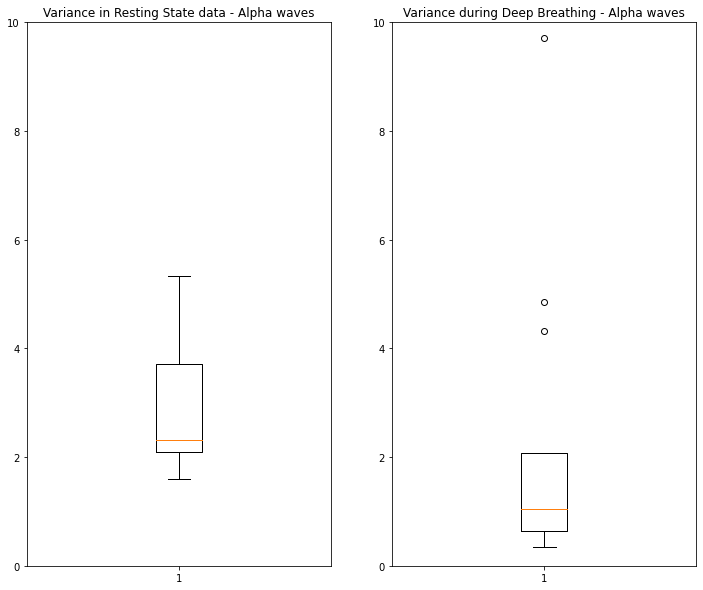

In [13]:
print ("Electrode wise variance in resting state data - alpha waves")
for i in range (len(motor_elec_name)):
    print (motor_elec_name[i],"variance =\t",RS_variance_alpha[i])
print ("\n")

print ("Electrode wise variance in deep breathing data - alpha waves")
for i in range (len(motor_elec_name)):
    print (motor_elec_name[i],"variance =\t",DB_variance_alpha[i])
print ("\n")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 10))

axes[0].boxplot(RS_variance_alpha)
axes[0].set_ylim([0, 10])

axes[1].boxplot(DB_variance_alpha) 
axes[1].set_ylim([0, 10])

axes[0].title.set_text('Variance in Resting State data - Alpha waves')
axes[1].title.set_text('Variance during Deep Breathing - Alpha waves')
plt.show()

## Variance during Resting State and Deep Breathing - Beta range

Electrode wise variance in resting state data - beta waves
F3 variance =	 0.08048649683986941
Fz variance =	 0.09084230168518516
F4 variance =	 0.0913932552006382
FC1 variance =	 0.055342673754292276
FC2 variance =	 0.05238810226798486
C3 variance =	 0.03908883611660063
C4 variance =	 0.05506822351753666
CP1 variance =	 0.039271838545478235
CP2 variance =	 0.03800320693358139
P3 variance =	 0.10544916405982226
Pz variance =	 0.07037546447330482
P4 variance =	 0.10967164676639816


Electrode wise variance in deep breathing data - beta waves
F3 variance =	 0.08225235796098879
Fz variance =	 0.05552567228788529
F4 variance =	 0.036393556208697
FC1 variance =	 0.04201188031535526
FC2 variance =	 0.03024918609367113
C3 variance =	 0.03738867475433536
C4 variance =	 0.05845990652612956
CP1 variance =	 0.026018604613635695
CP2 variance =	 0.027950635398214914
P3 variance =	 0.10711005748733374
Pz variance =	 0.10071397787779268
P4 variance =	 0.18961308489191414




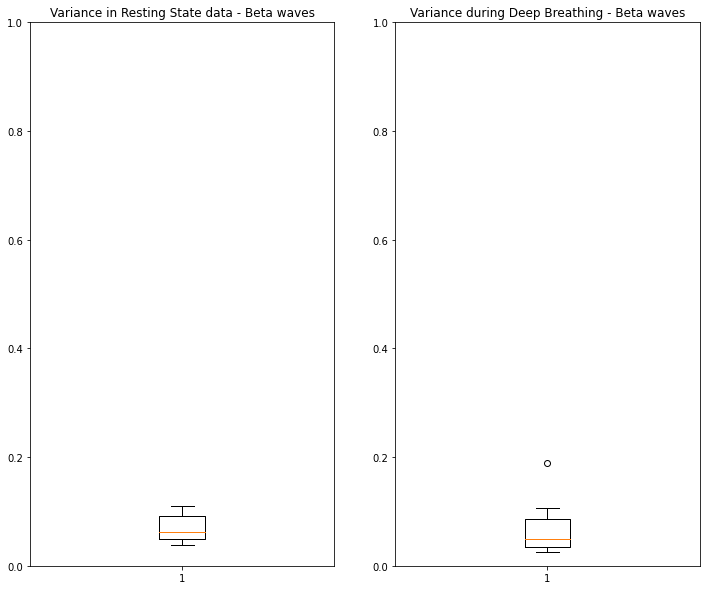

In [14]:
print ("Electrode wise variance in resting state data - beta waves")
for i in range (len(motor_elec_name)):
    print (motor_elec_name[i],"variance =\t",RS_variance_beta[i])
print ("\n")

print ("Electrode wise variance in deep breathing data - beta waves")
for i in range (len(motor_elec_name)):
    print (motor_elec_name[i],"variance =\t",DB_variance_beta[i])
print ("\n")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 10))

axes[0].boxplot(RS_variance_beta)
axes[0].set_ylim([0, 1])

axes[1].boxplot(DB_variance_beta) 
axes[1].set_ylim([0, 1])

axes[0].title.set_text('Variance in Resting State data - Beta waves')
axes[1].title.set_text('Variance during Deep Breathing - Beta waves')
plt.show()

## Variance during Resting State and Deep Breathing - Theta range

Electrode wise variance in resting state data - theta waves
F3 variance =	 0.9448934520690923
Fz variance =	 1.6097421830946708
F4 variance =	 0.9939137381021919
FC1 variance =	 1.1220000106590173
FC2 variance =	 0.9593751657053109
C3 variance =	 0.24937043871609588
C4 variance =	 0.2889026416814783
CP1 variance =	 0.38953507704269863
CP2 variance =	 0.47122839682535694
P3 variance =	 0.467042950407877
Pz variance =	 0.5979673303555084
P4 variance =	 0.576085755375441


Electrode wise variance in deep breathing data - theta waves
F3 variance =	 0.6528369186350282
Fz variance =	 0.6551006708184336
F4 variance =	 0.27479194784647887
FC1 variance =	 0.6572183969950179
FC2 variance =	 0.27476046775262103
C3 variance =	 0.15833104072757723
C4 variance =	 0.09985051768948809
CP1 variance =	 0.2627717215072529
CP2 variance =	 0.27220094175193427
P3 variance =	 0.4010720643963942
Pz variance =	 0.535291335976624
P4 variance =	 0.5682596514528419




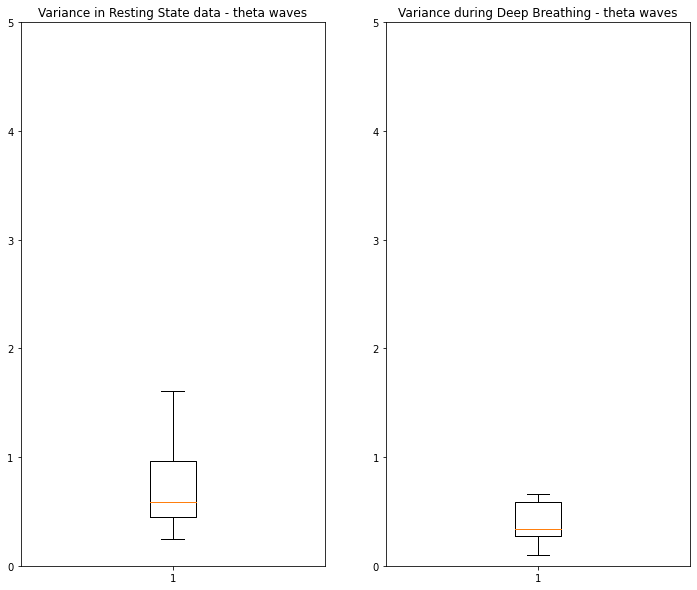

In [15]:
print ("Electrode wise variance in resting state data - theta waves")
for i in range (len(motor_elec_name)):
    print (motor_elec_name[i],"variance =\t",RS_variance_theta[i])
print ("\n")

print ("Electrode wise variance in deep breathing data - theta waves")
for i in range (len(motor_elec_name)):
    print (motor_elec_name[i],"variance =\t",DB_variance_theta[i])
print ("\n")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 10))

axes[0].boxplot(RS_variance_theta)
axes[0].set_ylim([0, 5])

axes[1].boxplot(DB_variance_theta) 
axes[1].set_ylim([0, 5])

axes[0].title.set_text('Variance in Resting State data - theta waves')
axes[1].title.set_text('Variance during Deep Breathing - theta waves')
plt.show()